# **Import Some Packages**

In [ ]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os

# **Download Data**

In [ ]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

--2021-12-29 05:22:30--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2021-12-29 05:22:30--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/master [following]
--2021-12-29 05:22:30--  https://codeload.github.com/karolpiczak/ESC-50/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [                <=>

In [ ]:
!unzip -qq master.zip

目前工作路徑

In [ ]:
%cd ESC-50-master

/content/ESC-50-master


讀取CVS檔，以便用來分類圖片名稱及所對應的類別 
>ex: (filename:1 -100038-A-14.wav >>> target:14	)





In [ ]:
df = pd.read_csv('meta/esc50.csv')

In [ ]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


# **Split train & valid set**
train set : fold 1-4

valid set : fold 5

In [ ]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [ ]:
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


# **轉換為梅爾譜圖Mel Spectrogram**
> 特徵存取，將音訊檔轉為Mel Spectrogram

In [ ]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [ ]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

# **Creat Dataset & DataLoader**

In [ ]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

<測試的例子，不一定要執行>

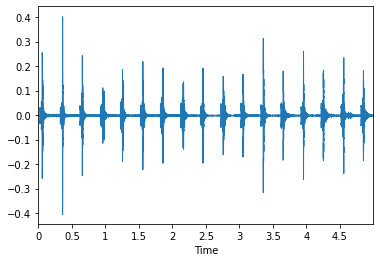

In [ ]:
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveplot(wav, sr)

<測試的例子，不一定要執行>

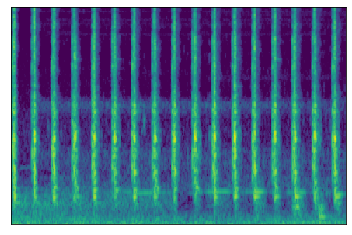

In [ ]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('audio/'+filename, sr)), cmap='viridis')

In [ ]:
train_data = ESC50Data('audio', train, 'filename', 'category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/1600 [00:00<?, ?it/s]

In [ ]:
valid_data = ESC50Data('audio', valid, 'filename', 'category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

# **Model**
> 更改Resnet50模型 (fc):輸出特徵變成50個

> 更改Resnet50模型 (conv1):三通道變成一通道

In [ ]:
from torchvision.models import resnet50
resnet_model = resnet50(pretrained=True)
resnet_model.fc = nn.Linear(2048,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

# **Train**
> setlr: 決定Optimizer的學習速率變化的函式

> lr_decay: 每10個epochs縮減其learning rate至1/10倍


In [ ]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [ ]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, valid_acc, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    acc=[]
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    valid_acc.append(accuracy)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [ ]:
learning_rate = 1e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate, weight_decay=1e-3)
epochs = 100
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
resnet_valid_acc=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, resnet_valid_acc, lr_decay)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.9777307391166685
Epoch - 1 Valid-Loss : 2.0614177997295675 Valid-Accuracy : 0.4875
Epoch - 2 Train-Loss : 1.37555251121521
Epoch - 2 Valid-Loss : 1.4914372334113488 Valid-Accuracy : 0.625
Epoch - 3 Train-Loss : 0.7167693412303925
Epoch - 3 Valid-Loss : 1.2786799990213835 Valid-Accuracy : 0.6325
Epoch - 4 Train-Loss : 0.4050765484571457
Epoch - 4 Valid-Loss : 1.22993803024292 Valid-Accuracy : 0.6525
Epoch - 5 Train-Loss : 0.25159311458468436
Epoch - 5 Valid-Loss : 1.1440248993726878 Valid-Accuracy : 0.67
Epoch - 6 Train-Loss : 0.15922144807875158
Epoch - 6 Valid-Loss : 1.0599370644642756 Valid-Accuracy : 0.725
Epoch - 7 Train-Loss : 0.0973091808706522
Epoch - 7 Valid-Loss : 1.055173057776231 Valid-Accuracy : 0.72
Epoch - 8 Train-Loss : 0.05177879571914673
Epoch - 8 Valid-Loss : 1.0393425959807177 Valid-Accuracy : 0.72
Epoch - 9 Train-Loss : 0.07032648578286171
Epoch - 9 Valid-Loss : 1.1475487901614263 Valid-Accuracy : 0.6825
Changed learning rate to 1e-05
Epoch 

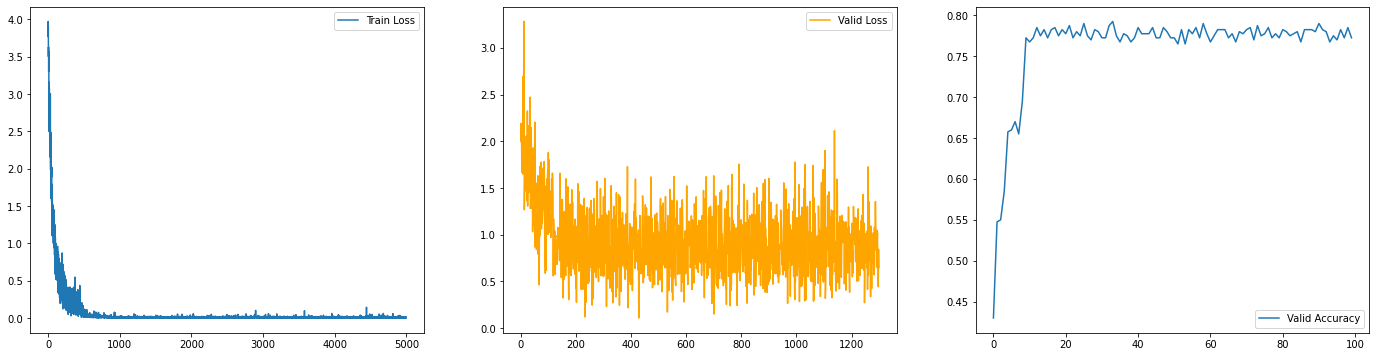

In [ ]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
vl_acc = np.asarray(resnet_valid_acc).ravel()
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,3,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
plt.subplot(1,3,3)
plt.plot(vl_acc)
plt.legend(['Valid Accuracy'])

# **Save model & data**

In [ ]:
with open('esc50resnet.pth','wb') as f:
  torch.save(resnet_model, f)

In [ ]:
import pickle
with open('indtocat.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)